In [31]:
import pandas as pd
import numpy as np
import emoji
import pickle
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
sentiment_data = pd.read_csv("../resource/Emoji_Sentiment_Ranking/Emoji_Sentiment_Data_v1.0.csv")

In [3]:
sentiment_data.head()

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons


In [4]:
def clean(x):
    x = x.replace(" ", "-").lower()
    return str(x)

sentiment_data['Unicode name'] = sentiment_data['Unicode name'].apply(clean)

In [5]:
sentiment_data.head()

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,face-with-tears-of-joy,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,heavy-black-heart,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,black-heart-suit,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,smiling-face-with-heart-shaped-eyes,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,loudly-crying-face,Emoticons


In [6]:
name_2_score = {}
for i in range(len(sentiment_data)) : 
        name_2_score[sentiment_data.loc[i, "Unicode name"]] = [sentiment_data.loc[i, "Negative"],
                                                               sentiment_data.loc[i, "Neutral"],
                                                               sentiment_data.loc[i, "Positive"]]

In [7]:
name_2_score['angry-face']

[163, 49, 76]

### Dumping name_2_score as pickle file

In [8]:
with open('../lib/name_2_score.pickle', 'wb') as handle:
    pickle.dump(name_2_score, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open('../lib/name_2_score.pickle', 'rb') as handle:
    name_2_score = pickle.load(handle)


### Image pre-processing

In [15]:
img = cv2.imread('../resource/screenshots/Trisha_2.jpeg')

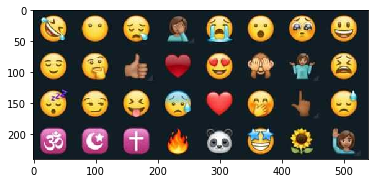

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
img.shape

(240, 540, 3)

#### Resizing image : dim = (560, 280)

In [18]:
dim = (560,280)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

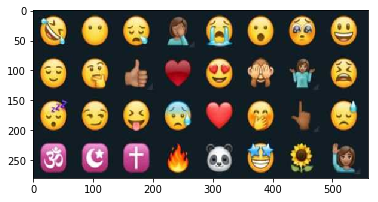

In [19]:
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
resized.shape

(280, 560, 3)

In [22]:
n_col = resized.shape[1]//2
    
img_left = resized[:, :n_col]
print("img_left",img_left.shape)

img_right = resized[:, n_col:]
print("img_right",img_right.shape)

img_left (280, 280, 3)
img_right (280, 280, 3)


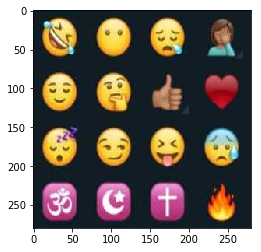

In [23]:
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.show()

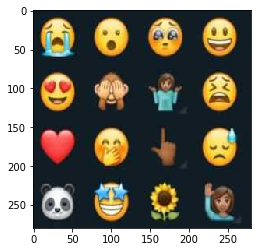

In [24]:
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()

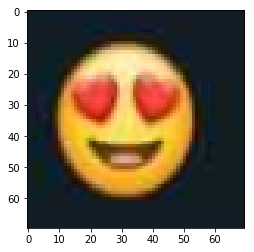

In [25]:
i = 1
j = 0
temp = img_right[i*70:(i+1)*70,j*70:(j+1)*70]
plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
plt.show()

### Final code for image processing

In [61]:
# takes input the image outputs the extracted emojis as np-arrays
def image_2_emoji(file_path):
    
    def to_half(image):
        
        n_col = image.shape[1]//2

        img_left = image[:, :n_col]
        img_right = image[:, n_col:]

        return (img_left, img_right)

    def extract_from_half(image):
        
        emoji_list = []
        for i in range(4):
            for j in range(4):
                temp = image[i*70:(i+1)*70,j*70:(j+1)*70]
                emoji_list.append(temp)
        return emoji_list
    
    img = cv2.imread(file_path)
    
    dim = (560,280)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    
    halfed = to_half(resized)
    
    output = extract_from_half(halfed[0])
    output += extract_from_half(halfed[1])
    
    return output

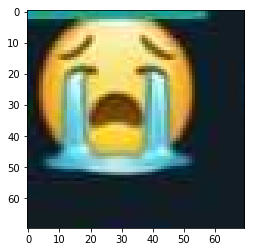

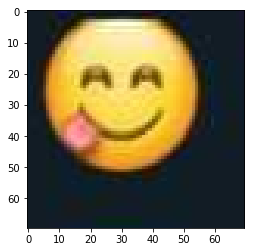

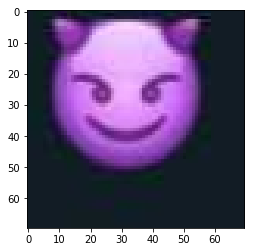

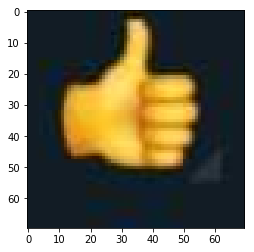

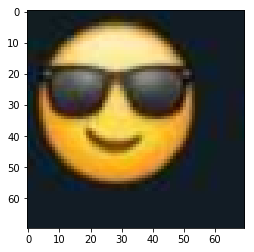

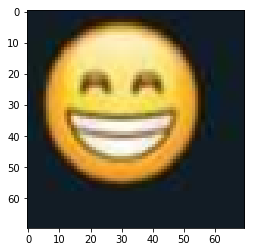

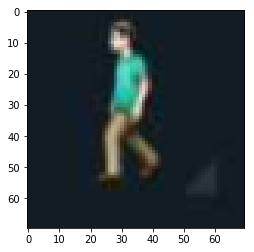

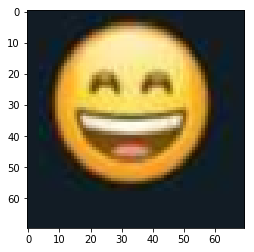

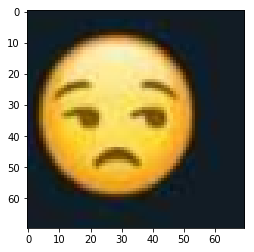

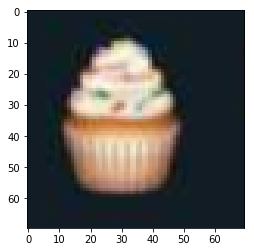

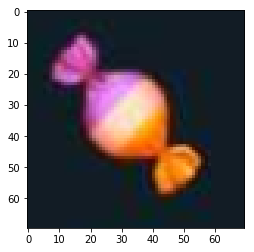

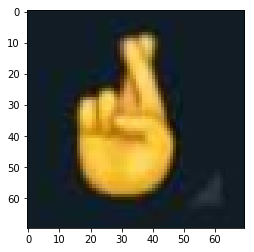

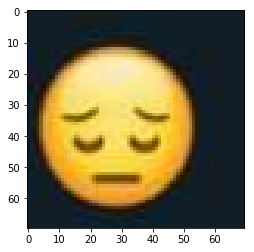

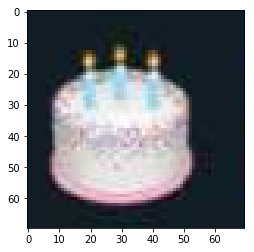

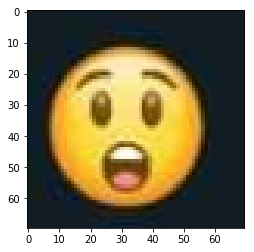

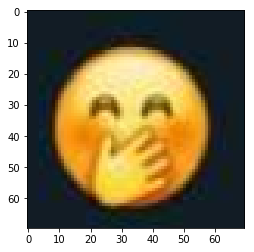

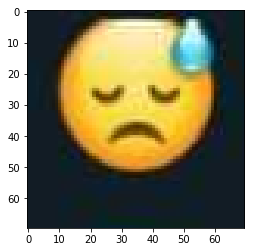

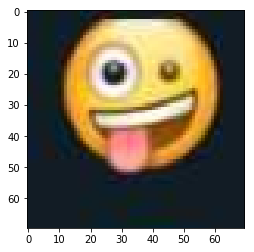

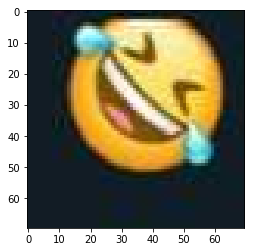

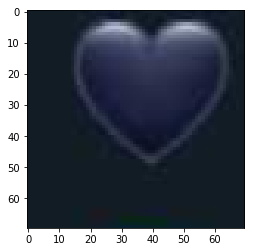

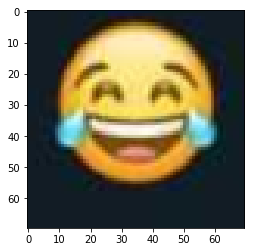

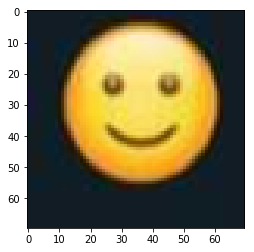

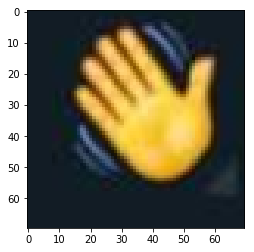

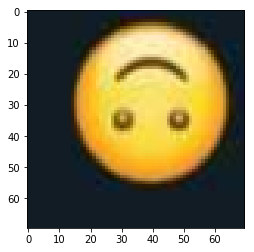

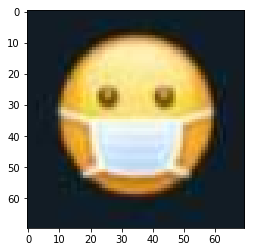

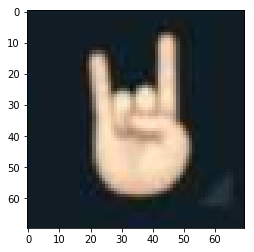

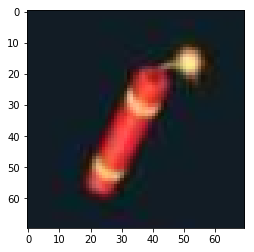

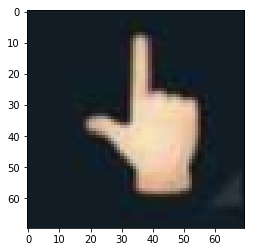

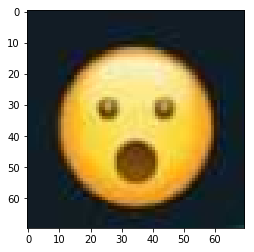

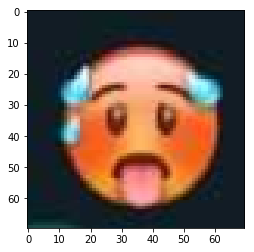

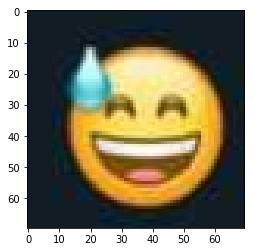

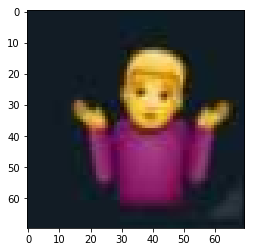

In [62]:
# Illustration
file_path = '../resource/screenshots/Anirban.jpeg'

l = image_2_emoji(file_path)

for i in l:
    plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    plt.show()

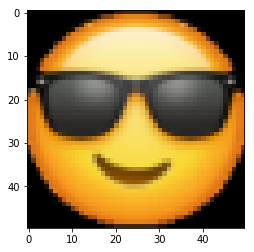

In [28]:
template = cv2.imread('../resource/emoji_database/smiling-face-with-sunglasses_1f60e.png')

dim = (50,50)
template = cv2.resize(template, dim, interpolation = cv2.INTER_AREA) 

plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.show()

### Each emoji after extraction has shape (70 $\times$ 70)
### Each template has size shape (50 $\times$ 50)

In [39]:
# Takes file_path of the screenshot as input and outputs the predicted list of names of the emojis
def image_2_name(file_path, method = 'cv2.TM_SQDIFF_NORMED'):
    
    '''
    available methods : 'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    '''
    
    methods = eval(method)
    emoji_list = image_2_emoji(file_path)
    emoji_name_list = [0]*len(emoji_list)
    output = [0]*len(emoji_list)
    
    for i in os.listdir('../resource/emoji_database'):
        
        template = cv2.imread('../resource/emoji_database/' + str(i))
        dim = (50,50)
        template = cv2.resize(template, dim, interpolation = cv2.INTER_AREA) 

        for j in range(len(emoji_list)):
            
            res = cv2.matchTemplate(emoji_list[j][:, :, 0] ,template[:, :, 0],methods)

            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            try:
                if emoji_name_list[j][0]>min_val:
                    emoji_name_list[j] = (min_val, i)
            except TypeError:
                emoji_name_list[j] = (min_val, i)
            output[j] = emoji_name_list[j][1].split('_')[0]
    
    #return emoji_name_list                    
    return output
    

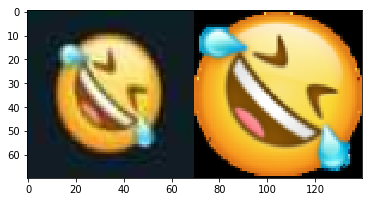

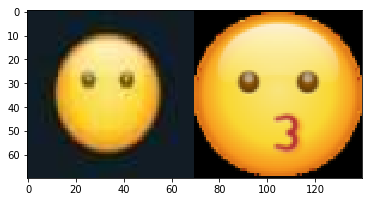

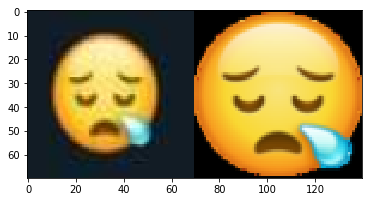

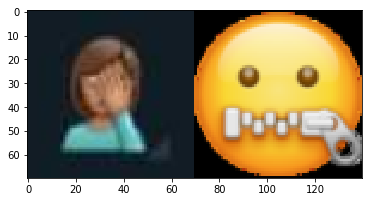

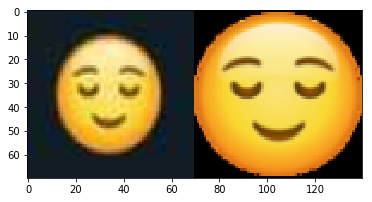

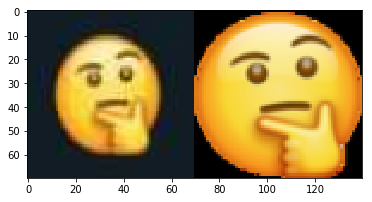

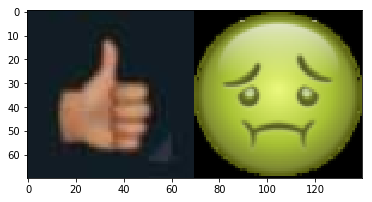

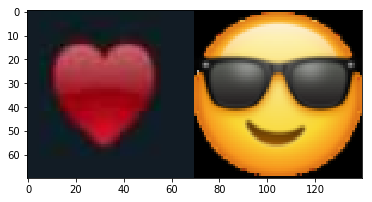

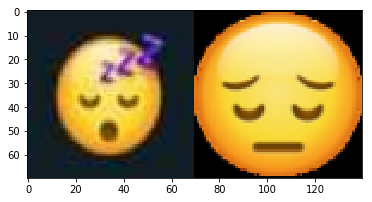

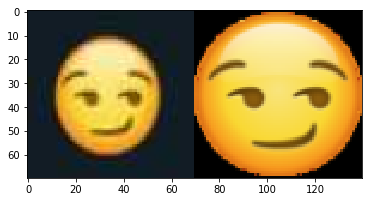

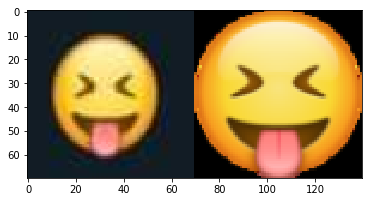

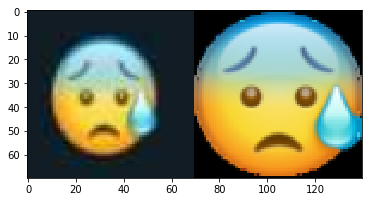

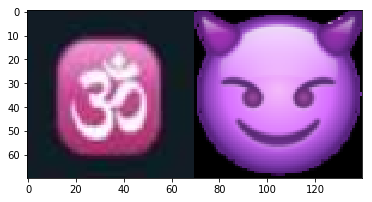

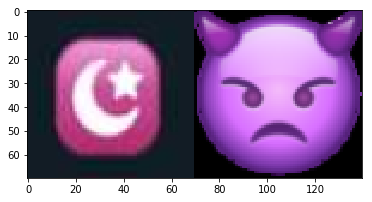

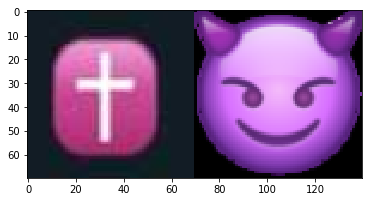

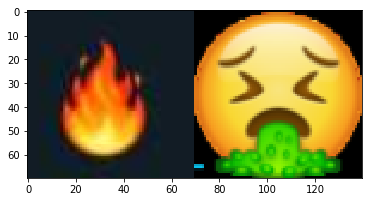

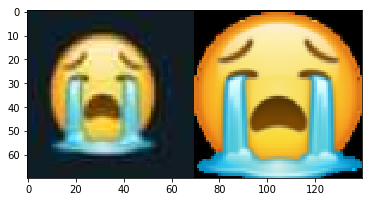

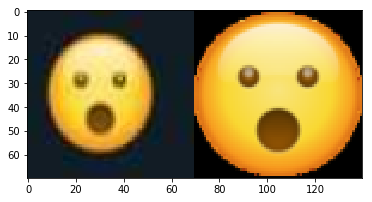

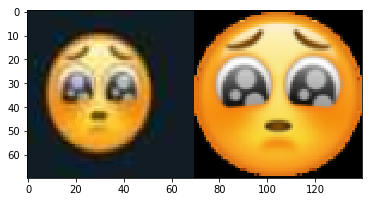

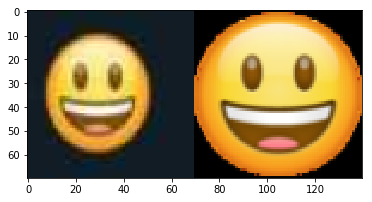

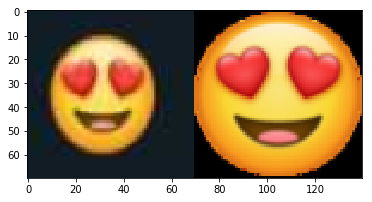

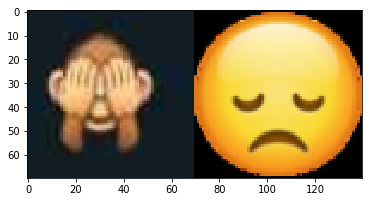

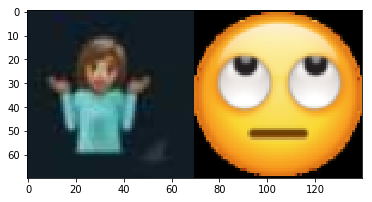

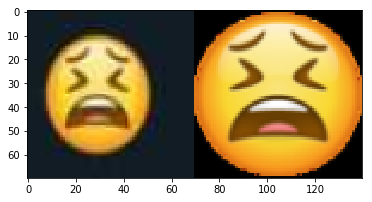

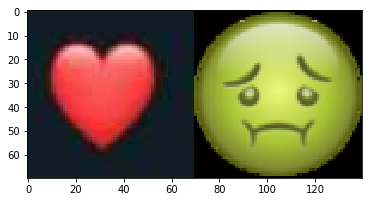

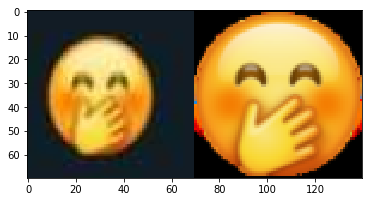

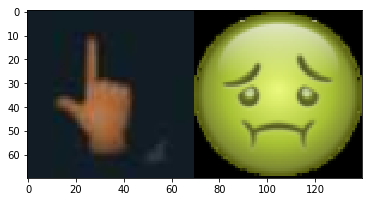

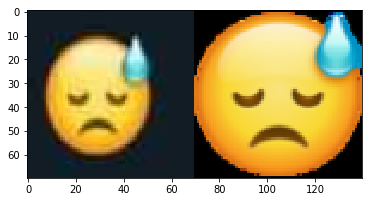

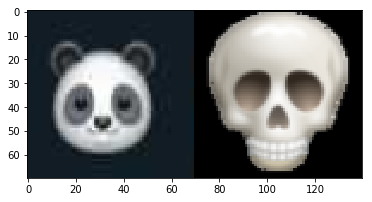

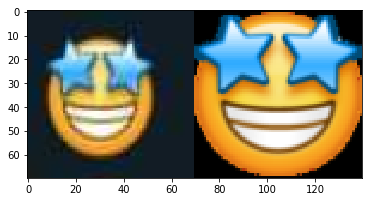

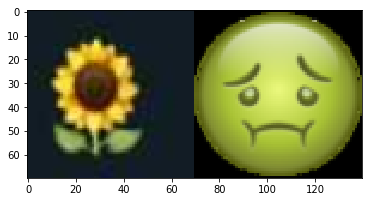

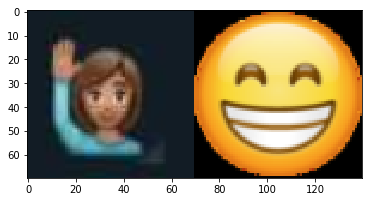

In [37]:
# Illustration

file_path = '../resource/screenshots/Trisha_2.jpeg'

l = image_2_name(file_path) # turn on the commented output for image_2_name
l_1 = image_2_emoji(file_path)

for i in range(32):
    img_pred = cv2.imread('../resource/emoji_database/' +l[i][1])
    img_orig = l_1[i]
    
    img_pred = cv2.resize(img_pred, (70,70), interpolation = cv2.INTER_AREA) 
    
    final = np.concatenate((img_orig, img_pred), axis=1)

    plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
    plt.show()

In [60]:
l = image_2_name(file_path)
for i in l:
    try:
        print(name_2_score[i])
    except KeyError:
        print("No data available for " + str(i))


No data available for rolling-on-the-floor-laughing
[1, 2, 12]
[208, 105, 169]
No data available for zipper-mouth-face
[93, 157, 415]
No data available for thinking-face
No data available for nauseated-face
[79, 224, 451]
[559, 263, 383]
[170, 676, 676]
[65, 155, 276]
[132, 44, 126]
[66, 106, 153]
[47, 15, 8]
[66, 106, 153]
No data available for face-with-open-mouth-vomiting
[2412, 1218, 1896]
[16, 33, 41]
No data available for face-with-pleading-eyes
[86, 361, 759]
[329, 1390, 4640]
[255, 85, 192]
No data available for face-with-rolling-eyes
[227, 81, 159]
No data available for nauseated-face
No data available for smiling-face-with-smiling-eyes-and-hand-covering-mouth
No data available for nauseated-face
[118, 59, 96]
[214, 123, 119]
No data available for grinning-face-with-star-eyes
No data available for nauseated-face
[278, 648, 1263]


#### Function to compute the sentiment score from the screenshots 

In [56]:
# takes the creenshot as input and returns the score
def image_2_score(file_path):
    
    output = None
    emoji_name_list = image_2_name(file_path)
    for i in emoji_name_list:
        try:
            output = np.add(output,np.array(name_2_score[i]))
        except TypeError:
            output = np.array(name_2_score[i])
        except KeyError:
            pass
    
    return output/np.sum(output)

In [59]:
image_2_score(file_path)

array([0.23307107, 0.25155854, 0.51537039])

## ROUGH

In [66]:
img = cv2.imread('../resource/screenshots/Arka.jpeg')

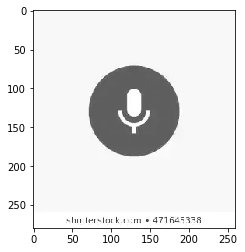

In [69]:
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.show()

In [55]:
im2_right[:, :, 0].shape

(280, 280)

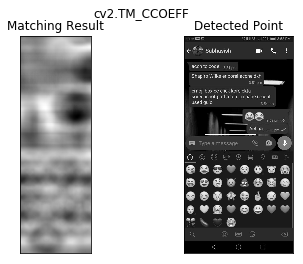

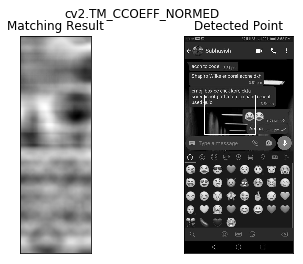

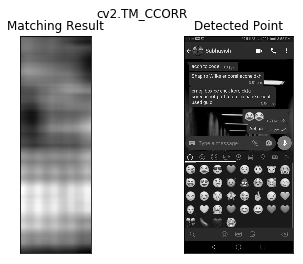

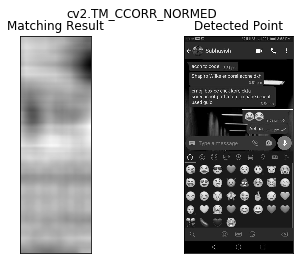

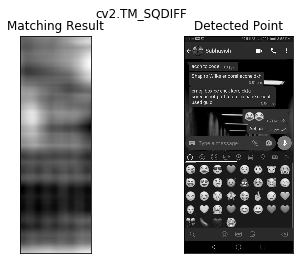

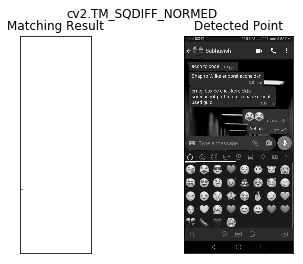

In [70]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../resource/screenshots/Arka.jpeg',0)
#img = im2_right[:, :, 2] 
img2 = img.copy()
template = cv2.imread('../resource/additional/mic.png',0)
#template = template[:, :, 2] 
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

In [50]:
res.shape

(746, 1005)

In [38]:
from PIL import Image
from matplotlib import pyplot

In [43]:
cv2.imshow(res, map = 'gray')

TypeError: Required argument 'mat' (pos 2) not found

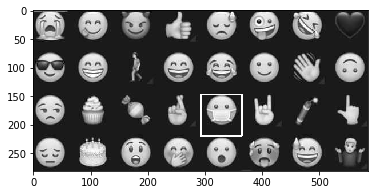

In [72]:


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


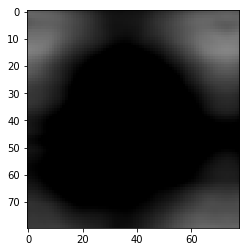

In [95]:
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

In [75]:
img

array([[26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       ...,
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26]], dtype=uint8)

In [86]:
for i in template:
    for j in range(len(i)):
        if i[j]==0:
            i[j]=26
            
        
    

In [87]:
template

array([[26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       ...,
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26]], dtype=uint8)

In [93]:
min_val, max_val, min_loc, max_loc

(0.49173372983932495, 1.0, (72, 14), (33, 18))